## Probabilistic Regime Forecast
Author: Adrien Loiseau

In [1]:
# Run the help_functions.py script to have acces to the imports and helper functions
%run help_functions.py

##### Load the dataset containing the 500 hPa geopotential height data

In [2]:
file_name = "Data/ERA5_geopotential_500hPa_1940_2025_winter_midnight_Euro_Atlantic.nc"
dataset_dict = load_dataset(file_name=file_name)

Geopotential height dataset (0.25°x0.25°): (nb_days=7731, nb_lats=241, nb_longs=561, grid_size=135201)
Geopotential height dataset (0.50°x0.50°): (nb_days=7731, nb_lats=121, nb_longs=281, grid_size=34001)
Geopotential height data: (7731, 121, 281)
Reshaped geopotential height data: (7731, 34001)
Geopotential height anomalies: (7731, 121, 281)
Reshaped geopotential height anomalies: (7731, 34001)
Daily winter data from 1940 to 2025 successfully loaded. Loading time: 54.40 seconds.


### Apply PCA to the geopotential height anomalies

In [3]:
nb_modes = 9
data_for_PCA = dataset_dict["geopotential_height_anomalies_reshaped"]

### Run PCA with nb_modes modes ###
start_time = time.time()
pca = PCA(n_components=nb_modes).fit(data_for_PCA)
end_time = time.time() ; print(f"PCA algorithm with {nb_modes} modes performed in {end_time-start_time:.2f} seconds.")

### Calculate the explained variance by the first nb_modes PCA modes ###
explained_variance = pca.explained_variance_ratio_ * 100
print(f"Total explained variance by the first {nb_modes} PCA modes: {explained_variance.sum():.2f}%")

### Transform the geopotential height anomalies using the PCA model (Project the data onto the first nb_modes PCA modes) ###
PCA_transformed_data = pca.transform(data_for_PCA)
print(f"Transformed geopotential height shape: {PCA_transformed_data.shape}")
print(f"Principal components shape: {pca.components_.shape}")

data_for_clustering = PCA_transformed_data

PCA algorithm with 9 modes performed in 4.66 seconds.
Total explained variance by the first 9 PCA modes: 76.09%
Transformed geopotential height shape: (7731, 9)
Principal components shape: (9, 34001)


In [4]:
def plot_centroids(nb_clusters, cluster_centers, y_pred, method, cluster_names=None):
    nb_lats = len(dataset_dict["lats"]) ; nb_longs = len(dataset_dict["longs"])

    ### Project the cluster centers back to the original space ###
    centroids_original_space = (cluster_centers @ pca.components_).reshape(nb_clusters, nb_lats, nb_longs)

    ### Sort the clusters in descending order of their frequency of occurrence ###
    frequency_array = np.array([np.sum(y_pred == cluster_idx) / len(y_pred) * 100 for cluster_idx in range(nb_clusters)]) ; sorted_indices = np.argsort(frequency_array)[::-1]

    ncols = 4 ; nrows = int(np.ceil(nb_clusters / ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3+1), constrained_layout=True)

    for cluster_idx in range(nrows*ncols): # Loop over the cluster indices (starting from 0 --> +1)
        row = cluster_idx // ncols ; col = cluster_idx % ncols ; axis_to_plot = axs[col] if (nrows == 1) else axs[row, col]

        if (cluster_idx < nb_clusters):
            if cluster_names is not None: axis_to_plot.set_title(f"Centroid {cluster_idx+1}: {cluster_names[cluster_idx]} ({frequency_array[sorted_indices[cluster_idx]]:.1f}%)", fontsize=20)
            else: axis_to_plot.set_title(f"Centroid {cluster_idx+1} ({frequency_array[sorted_indices[cluster_idx]]:.2f}%)", fontsize=20)
            ### Create the contour plot ###
            m, contour, ticks = create_contour_data(ax=axis_to_plot, dataset_dict=dataset_dict, type_plot="geopotential_height_anomalies_temporal_mean",
                                                    geopotential_height_data_to_plot=(centroids_original_space[sorted_indices[cluster_idx], :]), weather_regime=True)
        else: axis_to_plot.set_visible(False)

    fig.suptitle(f"Centroids {method} ({nb_clusters} clusters)", fontsize=20)
    cbar = fig.colorbar(contour, ax=axs, ticks=ticks, location='bottom', extend='both', shrink=0.75, pad=0.05, aspect=40)
    cbar.ax.tick_params(axis="x", labelsize=15)
    cbar.ax.text(x=1.1, y=-0.5, s=r'$[m]$', transform=cbar.ax.transAxes, ha='center', va='center', fontsize=13) # The coordinate system of the Axes: (0, 0) is bottom left, and (1, 1) is top right.
    plt.show()

---
## Four clusters
---

In [5]:
nb_clusters = 4 ; n_init = 1000
start_time = time.time()
kmeans_4 = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering) ; y_pred_kmeans_4 = kmeans_4.predict(data_for_clustering)
end_time = time.time() ; print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

frequency_array_kmeans_4 = np.bincount(y_pred_kmeans_4) / len(y_pred_kmeans_4) * 100
sorted_indices_kmeans_4 = np.argsort(frequency_array_kmeans_4)[::-1]
y_pred_sorted_kmeans_4 = np.array([np.argwhere(sorted_indices_kmeans_4 == y_pred_kmeans_4[day])[0][0] for day in range(len(y_pred_kmeans_4))])

K-Means algorithm with 4 clusters performed in 24.45 seconds.


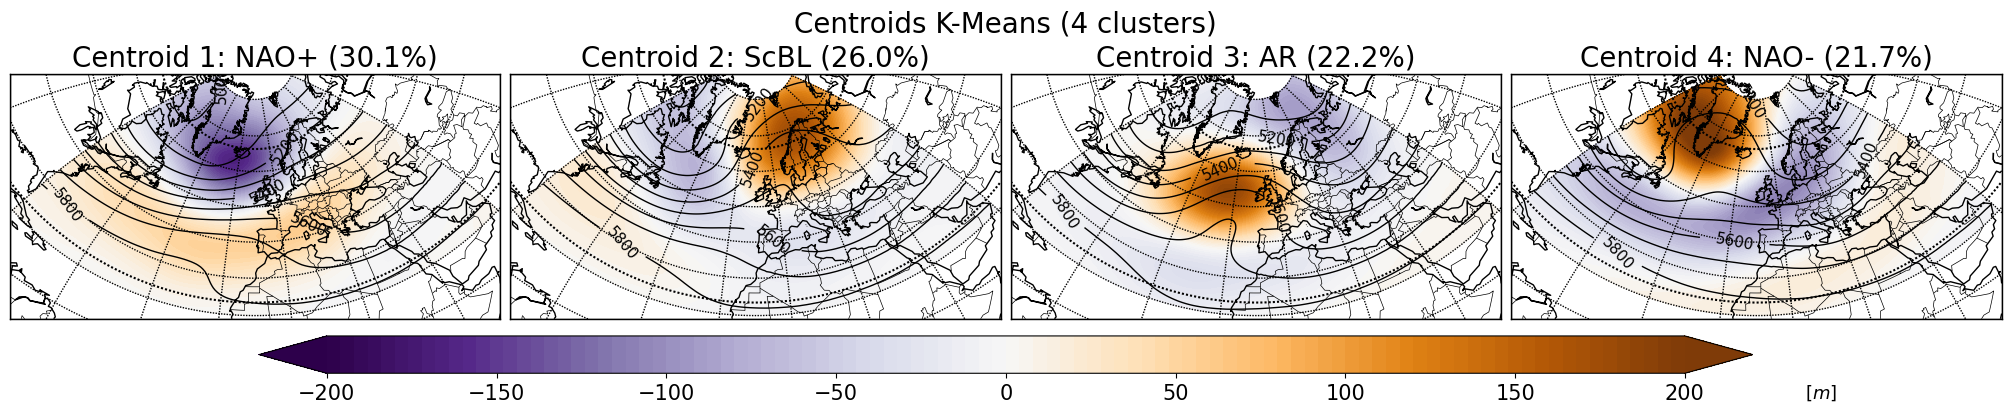

In [6]:
cluster_names_kmeans_4 = ["NAO+", "ScBL", "AR", "NAO-"]
plot_centroids(nb_clusters=len(cluster_names_kmeans_4), cluster_centers=kmeans_4.cluster_centers_, y_pred=y_pred_kmeans_4, method="K-Means", cluster_names=cluster_names_kmeans_4)

In [7]:
def create_transition_matrix(nb_clusters, y_pred_sorted):
    transition_matrix = np.zeros((nb_clusters, nb_clusters))
    for year in range(dataset_dict["first_year"], dataset_dict["last_year"]+1, 1):
        if (year == dataset_dict["first_year"]): first_day_idx = 0 ; last_day_idx = 60 # First (incomplete) winter
        elif (year % 4 == 0): first_day_idx = last_day_idx ; last_day_idx += 91 # Leap year
        else: first_day_idx = last_day_idx ; last_day_idx += 90 # Non-leap year

        for day in range(first_day_idx, last_day_idx-1, 1): # Don't include the last day as we are interested in the transition to the next day
            transition_matrix[y_pred_sorted[day], y_pred_sorted[day+1]] += 1

    ### Normalize the transition matrix ###
    transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True) * 100

    return transition_matrix

### Plot the transition matrix between the four clusters of K-Means  ###

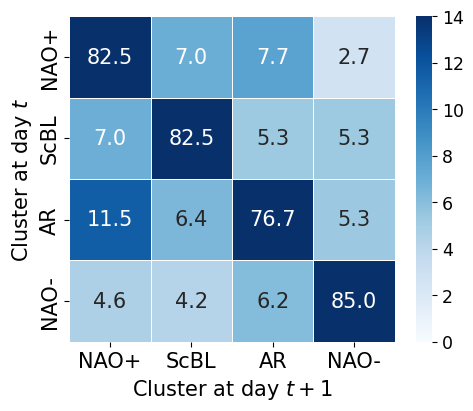

In [8]:
method = "KMeans" ; nb_clusters = 4 ; heatmap_labels = cluster_names_kmeans_4 # heatmap_labels = np.arange(nb_clusters)+1
transition_matrix_kmeans_4 = create_transition_matrix(nb_clusters=nb_clusters, y_pred_sorted=y_pred_sorted_kmeans_4)

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
ax = sns.heatmap(transition_matrix_kmeans_4, annot=True, annot_kws={"size":15}, fmt=".1f", linewidths=0.5, cmap="Blues", cbar=True, vmin=0, vmax=14, ax=ax, square=True, xticklabels=heatmap_labels, yticklabels=heatmap_labels)
ax.set_xlabel("Cluster at day $t+1$", fontsize=15) ; ax.set_ylabel("Cluster at day $t$", fontsize=15) ; ax.tick_params(labelsize=15)
cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=12.5)
# plt.savefig(f"Images/transition_matrix_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

### Plot the transition matrix between the four clusters identified in *Matsueda and Palmer, 2018* ###

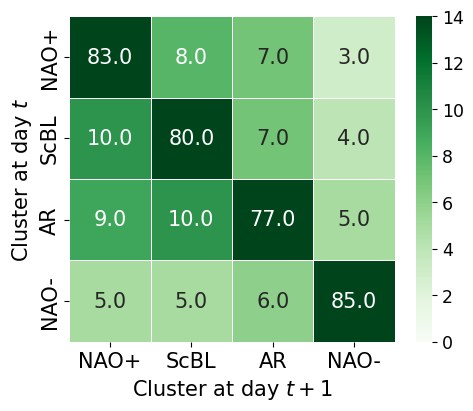

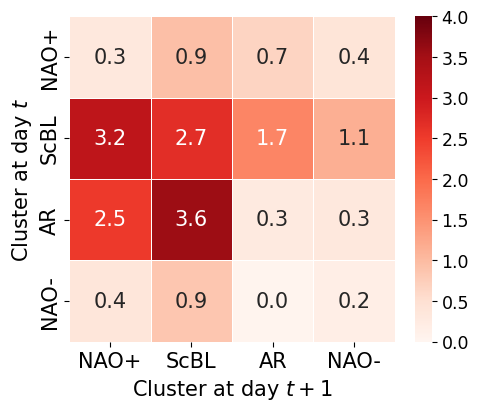

In [ ]:
transition_matrix_Matsueda_2018 = np.array([[83, 8, 7, 3], [10, 80, 7, 4], [9, 10, 77, 5], [5, 5, 6, 85]])

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
ax = sns.heatmap(transition_matrix_Matsueda_2018, annot=True, annot_kws={"size":15}, fmt=".1f", linewidths=0.5, cmap="Greens", cbar=True, vmin=0, vmax=14, ax=ax, square=True, xticklabels=heatmap_labels, yticklabels=heatmap_labels)
ax.set_xlabel("Cluster at day $t+1$", fontsize=15) ; ax.set_ylabel("Cluster at day $t$", fontsize=15) ; ax.tick_params(labelsize=15)
cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=12.5)
# plt.savefig(f"Images/transition_matrix_Matsueda_2018.png", dpi=300, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
ax = sns.heatmap(np.abs(transition_matrix_Matsueda_2018 - transition_matrix_kmeans_4), annot=True, annot_kws={"size":15}, fmt=".1f", linewidths=0.5, cmap="Reds", cbar=True, vmin=0, vmax=4, ax=ax, square=True, xticklabels=heatmap_labels, yticklabels=heatmap_labels)
ax.set_xlabel("Cluster at day $t+1$", fontsize=15) ; ax.set_ylabel("Cluster at day $t$", fontsize=15) ; ax.tick_params(labelsize=15)
cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=12.5)
# plt.savefig(f"Images/transition_matrix_KMeans_vs_Matsueda_2018.png", dpi=300, bbox_inches="tight")
plt.show()

In [49]:
def plot_ensemble_predictions(y_pred, ensemble_predictions, cluster_names, nb_clusters, actual_nb_days_to_forecast, savefig, winter_year=1940):
    nb_ensembles = len(ensemble_predictions[0, :]) # Number of ensemble members

    ### Percentage of attributions of each cluster ###
    cluster_attribution = np.zeros((len(ensemble_predictions), nb_clusters))
    for day in range(len(ensemble_predictions)):
        for ensemble in range(nb_ensembles):
            cluster_attribution[day, int(ensemble_predictions[day, ensemble])] += 1
    cluster_attribution = cluster_attribution / nb_ensembles * 100

    color_mapping = matplotlib.colormaps.get_cmap("tab10") # Create a color mapping for the clusters
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5), constrained_layout=True, sharex=True, height_ratios=[20, 1, 1])

    ### Plot the ensemble predictions
    for cluster in range(nb_clusters):
        axs[0].bar(x=np.arange(len(cluster_attribution)), height=cluster_attribution[:, cluster], \
                    bottom=np.sum(cluster_attribution[:, :cluster], axis=1), color=color_mapping(cluster), label=f"{cluster_names[cluster]}")
    axs[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.175), ncols=nb_clusters, fontsize=12, edgecolor='black')
    axs[0].tick_params(labelsize=12) ; axs[0].set_ylabel("Forecast probability [%]", fontsize=12)
    axs[0].margins(x=0.005, y=0.005) ; axs[0].set_xticks(np.arange(len(cluster_attribution)), minor=True) # Add minor ticks for each day
    axs[0].tick_params(which='major', length=10, width=1) ; axs[0].tick_params(which='minor', length=4, width=1)

    ### Plot the most frequent cluster among the ensemble predictions
    ensemble_predicted_colors = []
    for idx in range(len(cluster_attribution)):
        ensemble_predicted_colors.append(color_mapping(int(np.argmax(cluster_attribution[idx, :]))))
    axs[1].bar(x=np.arange(len(cluster_attribution)), height=1, color=ensemble_predicted_colors) ; axs[1].set_yticks([]) ; axs[1].margins(x=0, y=0)

    ### Plot the predicted clusters from the model
    predicted_colors = []
    for idx in range(len(cluster_attribution)):
        predicted_colors.append(color_mapping(y_pred[idx]))
    axs[2].bar(x=np.arange(len(cluster_attribution)), height=1, color=predicted_colors) ; axs[2].set_yticks([]) ; axs[2].margins(x=0, y=0)

    ### Set the x-axis ticks and labels as days-month
    ticks_labels = []
    if (winter_year == dataset_dict["first_year"]): months = ["01", "02"]
    else: months = ["12", "01", "02"]
    # months = ["02"]
    for day in range(0, len(cluster_attribution), 5):
        month_idx = day // 31 ; day_in_month = day % 31
        ticks_labels.append(f"{day_in_month+1:02d}-{months[month_idx]}")
    axs[2].set_xticks(ticks=np.arange(0, len(cluster_attribution), 5), labels=ticks_labels, rotation=45, fontsize=12)
    axs[2].set_xticks(np.arange(len(cluster_attribution)), minor=True) # Add minor ticks for each day
    axs[2].tick_params(which='major', length=10, width=1) ; axs[2].tick_params(which='minor', length=4, width=1)

    if (savefig == True): plt.savefig(f"Images/ensemble_predictions_{winter_year}_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
    plt.show()

    return cluster_attribution

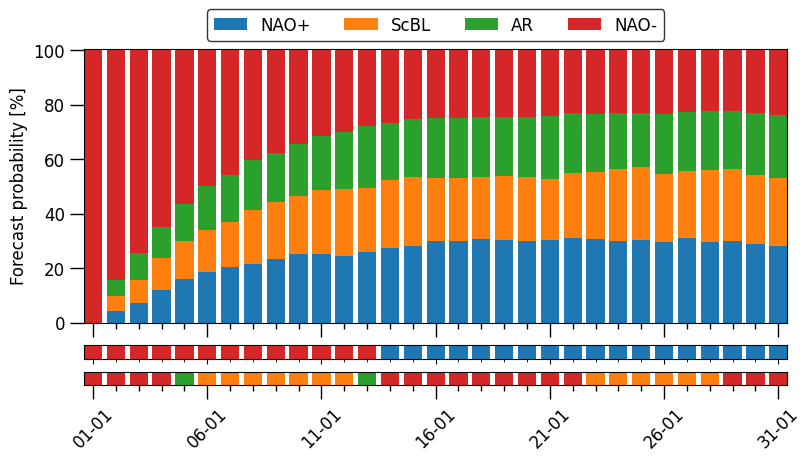

In [ ]:
cluster_names = cluster_names_kmeans_4
actual_nb_days_to_forecast = 30 # The number of days to forecast is limited by the number of days left in the winter
nb_days_in_forecast = actual_nb_days_to_forecast + 1
ensemble_predictions = compute_forecast_probabilities(nb_clusters=4, transition_matrix=transition_matrix_kmeans_4/100, y_pred=y_pred_sorted_kmeans_4, \
                initial_day_idx=0, actual_nb_days_to_forecast=actual_nb_days_to_forecast, nb_ensembles=1000)

y_pred = y_pred_sorted_kmeans_4[:nb_days_in_forecast] # Get the predicted clusters for the winter year (the first nb_days_in_forecast days)
cluster_attribution_kmeans_4 = plot_ensemble_predictions(y_pred=y_pred, ensemble_predictions=ensemble_predictions, cluster_names=cluster_names_kmeans_4, \
                                                         nb_clusters=nb_clusters, actual_nb_days_to_forecast=actual_nb_days_to_forecast, savefig=False, winter_year=1940)

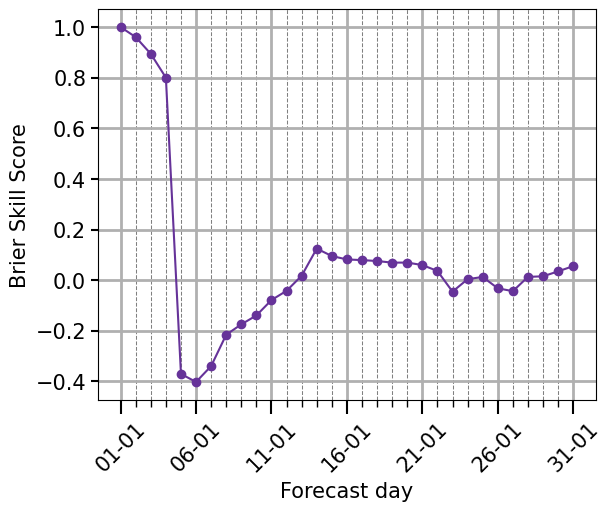

In [155]:
def example_forecast(cluster_attribution, brier_score, savefig, winter_year):
    ### Compute the Brier score for the ensemble predictions ###
    persistence_proba_each_regime_4 = frequency_array_kmeans_4[sorted_indices_kmeans_4] / 100 ; nb_clusters = 4 ; first_day_idx = 0
    brier_scores_ensemble = np.zeros(len(cluster_attribution)) ; dummy_brier_scores_ensemble = np.zeros(len(cluster_attribution))
    for day in range(len(cluster_attribution)):
        brier_scores_ensemble[day] = np.sum((cluster_attribution[day, :] / 100 - (y_pred_sorted_kmeans_4[first_day_idx + day] == np.arange(nb_clusters)))**2)
        # print(f"Day {day+1} - Brier score: {brier_score:.2f} - {cluster_atcluster_attribution_4tribution[day, :] / 100} {y_pred_sorted_4[day] == np.arange(nb_clusters)}")
        dummy_brier_scores_ensemble[day] = np.sum((persistence_proba_each_regime_4 - (y_pred_sorted_kmeans_4[day] == np.arange(nb_clusters)))**2)

    fig, axs = plt.subplots(figsize=(6, 5), constrained_layout=True)
    if (brier_score == True):
        plt.plot(brier_scores_ensemble, marker="o", label="Probabilistic forecast", color="sienna")
        plt.plot(dummy_brier_scores_ensemble, label="Dummy forecast", color="olivedrab", marker="P")
        plt.ylabel("Brier Score", fontsize=15) ; plt.legend(fontsize=15, edgecolor='black', loc="upper right")
    else:
        plt.plot(1 - brier_scores_ensemble / dummy_brier_scores_ensemble, marker="o", color="rebeccapurple") ; plt.ylabel("Brier Skill Score", fontsize=15)

    plt.grid(linewidth=2) ; ax = plt.gca() ; ax.tick_params(labelsize=15) ; plt.xlabel("Forecast day", fontsize=15)

    ### Set the x-axis ticks and labels as days-month
    ticks_labels = []
    if (winter_year == dataset_dict["first_year"]): months = ["01", "02"]
    else: months = ["12", "01", "02"]
    for day in range(0, len(cluster_attribution), 5):
        month_idx = day // 31 ; day_in_month = day % 31
        ticks_labels.append(f"{day_in_month+1:02d}-{months[month_idx]}")
    ax.set_xticks(ticks=np.arange(0, len(cluster_attribution), 5), labels=ticks_labels, rotation=45)
    ax.set_xticks(np.arange(len(cluster_attribution)), minor=True) # Add minor ticks for each day
    ax.tick_params(which='major', axis='x', length=10, width=1.5) ; ax.tick_params(which='minor', length=5, width=1)
    ax.grid(which='minor', linestyle='--', linewidth=0.75, color='gray')
    ax.tick_params(which='major', axis='y', length=5, width=1.5) ; 

    if (savefig == True):
        if (brier_score == True): plt.savefig(f"Images/Brier_Scores_ensemble_{winter_year}.png", dpi=300, bbox_inches="tight")
        else: plt.savefig(f"Images/Brier_Skill_Scores_ensemble_{winter_year}.png", dpi=300, bbox_inches="tight")
    plt.show()

winter_year = 1940
# example_forecast(cluster_attribution=cluster_attribution_kmeans_4, brier_score=True, savefig=True, winter_year=winter_year) # True or False
example_forecast(cluster_attribution=cluster_attribution_kmeans_4, brier_score=False, savefig=True, winter_year=winter_year)

---
## Eight clusters
---

In [9]:
nb_clusters = 8 ; n_init = 1000
start_time = time.time()
kmeans_8 = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering) ; y_pred_kmeans_8 = kmeans_8.predict(data_for_clustering)
end_time = time.time() ; print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

frequency_array_kmeans_8 = np.bincount(y_pred_kmeans_8) / len(y_pred_kmeans_8) * 100
sorted_indices_kmeans_8 = np.argsort(frequency_array_kmeans_8)[::-1]
y_pred_sorted_kmeans_8 = np.array([np.argwhere(sorted_indices_kmeans_8== y_pred_kmeans_8[day])[0][0] for day in range(len(y_pred_kmeans_8))])

K-Means algorithm with 8 clusters performed in 35.86 seconds.


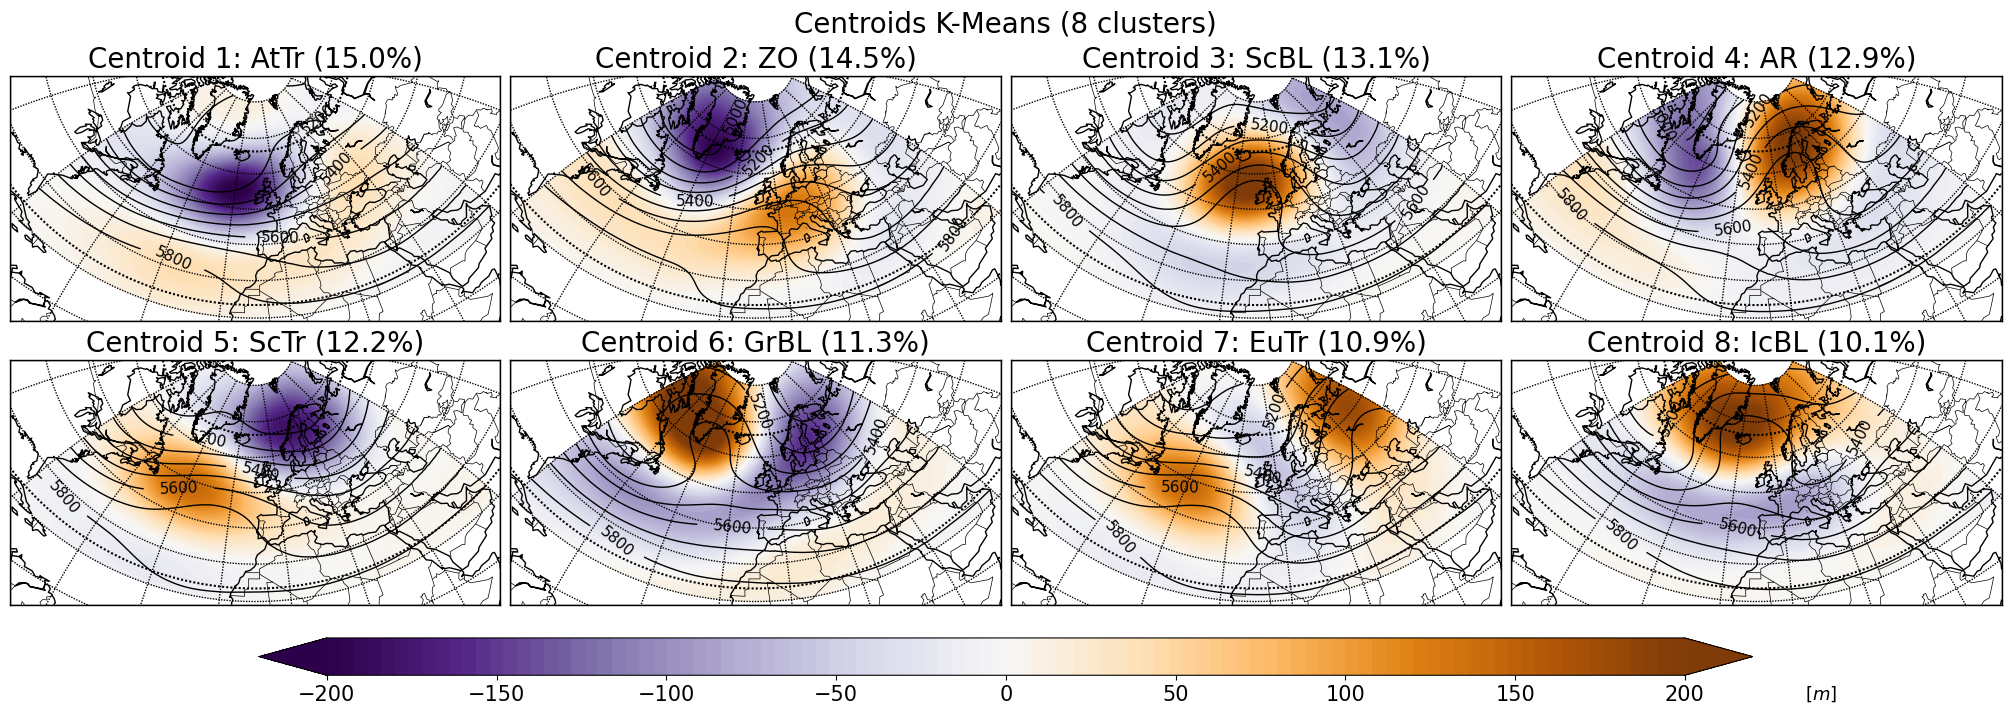

In [10]:
cluster_names_kmeans_8 = ["AtTr", "ZO", "ScBL", "AR", "ScTr", "GrBL", "EuTr", "IcBL"]
plot_centroids(nb_clusters=len(cluster_names_kmeans_8), cluster_centers=kmeans_8.cluster_centers_, y_pred=y_pred_kmeans_8, method="K-Means", cluster_names=cluster_names_kmeans_8)

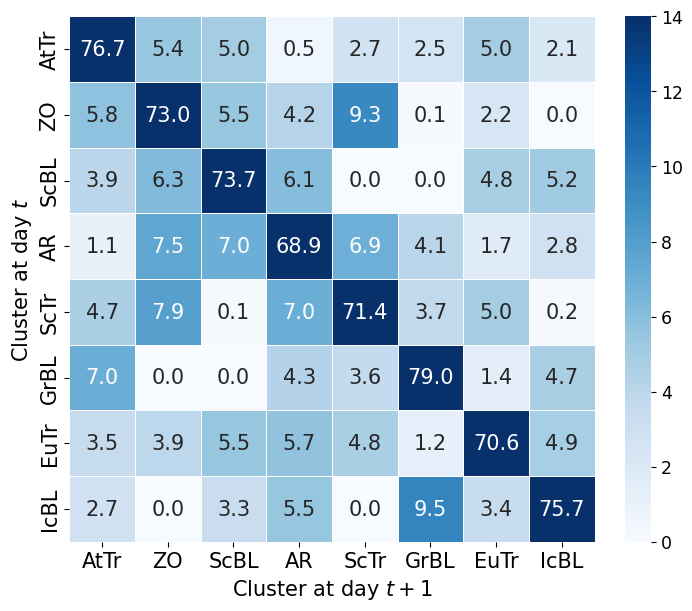

In [ ]:
method = "KMeans" ; nb_clusters = 8 ; heatmap_labels = cluster_names_kmeans_8 # heatmap_labels = np.arange(nb_clusters)+1
transition_matrix_kmeans_8 = create_transition_matrix(nb_clusters=nb_clusters, y_pred_sorted=y_pred_sorted_kmeans_8)

fig, ax = plt.subplots(figsize=(7,6), constrained_layout=True)
ax = sns.heatmap(transition_matrix_kmeans_8, annot=True, annot_kws={"size":15}, fmt=".1f", linewidths=0.5, cmap="Blues", cbar=True, vmin=0, vmax=14, ax=ax, square=True, xticklabels=heatmap_labels, yticklabels=heatmap_labels)
ax.set_xlabel("Cluster at day $t+1$", fontsize=15) ; ax.set_ylabel("Cluster at day $t$", fontsize=15) ; ax.tick_params(labelsize=15)
cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=12.5)
# plt.savefig(f"Images/transition_matrix_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
accuracy = 0
for day in range(len(y_pred_sorted_kmeans_8)):
    pred = np.random.choice(a=np.arange(nb_clusters), p=frequency_array_kmeans_8/100)
    accuracy += (pred == y_pred_sorted_kmeans_8[day])
print(f"Random prediction accuracy: {accuracy / len(y_pred_sorted_kmeans_8) * 100:.2f}%")

Random prediction accuracy: 12.47%


---
## Predictions
---

In [11]:
def compute_dummy_brier_scores(nb_clusters, y_pred, persistence_proba_each_regime, cluster_names):
    dummy_brier_scores = np.zeros(data_for_clustering.shape[0])
    for year in range(dataset_dict["first_year"], dataset_dict["last_year"]+1, 1):
        if (year == dataset_dict["first_year"]): first_day_idx = 0 ; last_day_idx = 60
        elif (year % 4 == 0): first_day_idx = last_day_idx ; last_day_idx += 91 # Leap year
        else: first_day_idx = last_day_idx ; last_day_idx += 90 # Non-leap year

        for day in range(first_day_idx, last_day_idx, 1):
            dummy_brier_scores[day] = np.sum((persistence_proba_each_regime - (y_pred[day] == np.arange(nb_clusters)))**2)

    mean_dummy_brier_scores = np.mean(dummy_brier_scores) ; print(f"Mean Brier score from persistence: {mean_dummy_brier_scores:.4f}")

    ### Equivalent formulation ###
    dummy_brier_scores_from_clusters = np.zeros(nb_clusters)
    for cluster_idx in range(nb_clusters):
        # dummy_brier_scores_from_clusters[cluster_idx] = np.mean(dummy_brier_scores[y_pred == cluster_idx])
        dummy_brier_scores_from_clusters[cluster_idx] = np.sum((persistence_proba_each_regime - (cluster_idx == np.arange(nb_clusters)))**2)
        print(f"Mean Brier score from persistence for cluster {cluster_names[cluster_idx]}: {dummy_brier_scores_from_clusters[cluster_idx]:.4f}")

    mean_dummy_brier_scores = np.sum(dummy_brier_scores_from_clusters * persistence_proba_each_regime) ; print(f"Mean Brier score from persistence: {mean_dummy_brier_scores:.4f}")

    return dummy_brier_scores_from_clusters, mean_dummy_brier_scores

In [12]:
# Compute the probabilitie of being in each state
persistence_proba_each_regime_kmeans_4 = np.array(frequency_array_kmeans_4[sorted_indices_kmeans_4] / 100)
print(f"Probability of being in each state: {persistence_proba_each_regime_kmeans_4}")
dummy_BS_4 = compute_dummy_brier_scores(nb_clusters=4, y_pred=y_pred_sorted_kmeans_4, persistence_proba_each_regime=persistence_proba_each_regime_kmeans_4, cluster_names=cluster_names_kmeans_4)
(dummy_BS_from_clusters_kmeans_4, mean_dummy_BS_kmeans_4) = dummy_BS_4

Probability of being in each state: [0.30073729 0.26038029 0.22235157 0.21653085]
Mean Brier score from persistence: 0.7454
Mean Brier score from persistence for cluster NAO+: 0.6531
Mean Brier score from persistence for cluster ScBL: 0.7338
Mean Brier score from persistence for cluster AR: 0.8099
Mean Brier score from persistence for cluster NAO-: 0.8215
Mean Brier score from persistence: 0.7454


In [13]:
persistence_proba_each_regime_kmeans_8 = np.array(frequency_array_kmeans_8[sorted_indices_kmeans_8] / 100)
print(f"Probability of being in each state: {persistence_proba_each_regime_kmeans_8}")
dummy_BS_8 = compute_dummy_brier_scores(nb_clusters=8, y_pred=y_pred_sorted_kmeans_8, persistence_proba_each_regime=persistence_proba_each_regime_kmeans_8, cluster_names=cluster_names_kmeans_8)
(dummy_BS_from_clusters_kmeans_8, mean_dummy_BS_kmeans_8) = dummy_BS_8

Probability of being in each state: [0.14991592 0.14500065 0.13103091 0.12934937 0.12197646 0.11305135
 0.10917087 0.10050446]
Mean Brier score from persistence: 0.8729
Mean Brier score from persistence for cluster AtTr: 0.8272
Mean Brier score from persistence for cluster ZO: 0.8371
Mean Brier score from persistence for cluster ScBL: 0.8650
Mean Brier score from persistence for cluster AR: 0.8684
Mean Brier score from persistence for cluster ScTr: 0.8831
Mean Brier score from persistence for cluster GrBL: 0.9010
Mean Brier score from persistence for cluster EuTr: 0.9087
Mean Brier score from persistence for cluster IcBL: 0.9261
Mean Brier score from persistence: 0.8729


In [14]:
def compute_transition_table(nb_days_in_state, first_year, last_year, y_pred_sorted, nb_clusters):
    transition_table = {}
    for year in range(first_year, last_year + 1, 1):
        if (year == dataset_dict["first_year"]): first_day_idx = 0 ; last_day_idx = 60
        elif (year % 4 == 0): first_day_idx = last_day_idx ; last_day_idx += 91 # Leap year
        else: first_day_idx = last_day_idx ; last_day_idx += 90 # Non-leap year

        for day in range(first_day_idx, last_day_idx - nb_days_in_state, 1):
            current_state = tuple(y_pred_sorted[day : day + nb_days_in_state]) # Get the current state as a tuple of the next nb_days_in_state days

            if (current_state not in transition_table):
                transition_table[current_state] = np.zeros(nb_clusters) # Initialize the transition counts for the current state
            
            transition_table[current_state][y_pred_sorted[day + nb_days_in_state]] += 1 # Increment the count for the next state

    # Normalize the transition counts to get probabilities
    transition_probabilities = {}
    for key, value in transition_table.items():
        total_transitions = np.sum(value)
        transition_probabilities[key] = value / total_transitions # Convert to percentage

    return transition_probabilities

In [15]:
transition_proba_kmeans_4_1_days = compute_transition_table(nb_days_in_state=1, first_year=dataset_dict["first_year"], last_year=2020, y_pred_sorted=y_pred_sorted_kmeans_4, nb_clusters=4)
transition_proba_kmeans_4_5_days = compute_transition_table(nb_days_in_state=5, first_year=dataset_dict["first_year"], last_year=2020, y_pred_sorted=y_pred_sorted_kmeans_4, nb_clusters=4)
transition_proba_kmeans_4_10_days = compute_transition_table(nb_days_in_state=10, first_year=dataset_dict["first_year"], last_year=2020, y_pred_sorted=y_pred_sorted_kmeans_4, nb_clusters=4)

In [16]:
nb_clusters = 4
nb_days_in_state = 1 ; all_states = set(transition_proba_kmeans_4_1_days.keys())
print(f"{len(all_states)} unique states in the transition probabilities. {nb_clusters ** nb_days_in_state} possible states for {nb_days_in_state} days in state.")

nb_days_in_state = 5 ; all_states = set(transition_proba_kmeans_4_5_days.keys())
print(f"{len(all_states)} unique states in the transition probabilities. {nb_clusters ** nb_days_in_state} possible states for {nb_days_in_state} days in state.")

nb_days_in_state = 10 ; all_states = set(transition_proba_kmeans_4_10_days.keys())
print(f"{len(all_states)} unique states in the transition probabilities. {nb_clusters ** nb_days_in_state} possible states for {nb_days_in_state} days in state.")

4 unique states in the transition probabilities. 4 possible states for 1 days in state.
362 unique states in the transition probabilities. 1024 possible states for 5 days in state.
2361 unique states in the transition probabilities. 1048576 possible states for 10 days in state.


In [17]:
transition_proba_kmeans_8_1_days = compute_transition_table(nb_days_in_state=1, first_year=dataset_dict["first_year"], last_year=2020, y_pred_sorted=y_pred_sorted_kmeans_8, nb_clusters=8)
transition_proba_kmeans_8_5_days = compute_transition_table(nb_days_in_state=5, first_year=dataset_dict["first_year"], last_year=2020, y_pred_sorted=y_pred_sorted_kmeans_8, nb_clusters=8)
transition_proba_kmeans_8_10_days = compute_transition_table(nb_days_in_state=10, first_year=dataset_dict["first_year"], last_year=2020, y_pred_sorted=y_pred_sorted_kmeans_8, nb_clusters=8)

In [19]:
nb_clusters = 8
nb_days_in_state = 1 ; all_states = set(transition_proba_kmeans_8_1_days.keys())
print(f"{len(all_states)} unique states in the transition probabilities. {nb_clusters ** nb_days_in_state} possible states for {nb_days_in_state} days in state.")

nb_days_in_state = 5 ; all_states = set(transition_proba_kmeans_8_5_days.keys())
print(f"{len(all_states)} unique states in the transition probabilities. {nb_clusters ** nb_days_in_state} possible states for {nb_days_in_state} days in state.")

nb_days_in_state = 10 ; all_states = set(transition_proba_kmeans_8_10_days.keys())
print(f"{len(all_states)} unique states in the transition probabilities. {nb_clusters ** nb_days_in_state} possible states for {nb_days_in_state} days in state.")

8 unique states in the transition probabilities. 8 possible states for 1 days in state.
1454 unique states in the transition probabilities. 32768 possible states for 5 days in state.
4736 unique states in the transition probabilities. 1073741824 possible states for 10 days in state.


[cftime.DatetimeProlepticGregorian(2024, 12, 10, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 11, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 12, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 13, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 14, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 15, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 17, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 18, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 19, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 20, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2024, 12, 21, 0, 0, 0, 0, has_year_zero=True)]
Initial state for forecasti

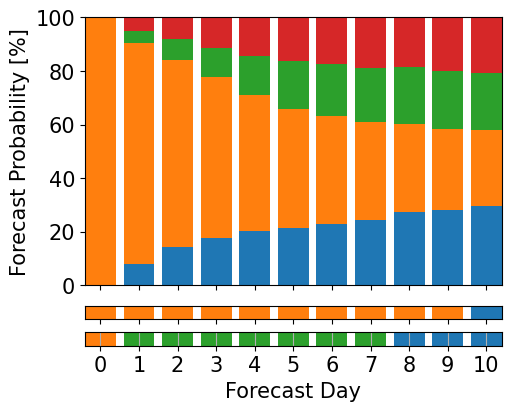

In [ ]:
def plot_forecast(nb_days_to_forecast, transition_probabilities, nb_days_in_state, nb_clusters):
    all_states = set(transition_probabilities.keys())
    state_to_idx = {state: idx for idx, state in enumerate(all_states)} # Create a mapping from state to index

    year_to_predict = 2025
    for year in range(dataset_dict["first_year"], year_to_predict+1, 1):
        if (year == dataset_dict["first_year"]): first_day_idx = 0 ; last_day_idx = 60
        elif (year % 4 == 0): first_day_idx = last_day_idx ; last_day_idx += 91 # Leap year
        else: first_day_idx = last_day_idx ; last_day_idx += 90 # Non-leap year

    first_day_idx = first_day_idx - nb_days_in_state + 10
    print(dataset_dict["dates"][first_day_idx : first_day_idx + nb_days_in_state + nb_days_to_forecast + 1]) # Print the dates for the forecast period

    initial_state = tuple(y_pred_sorted_kmeans_4[first_day_idx : first_day_idx + nb_days_in_state]) # Get the initial state as a tuple of the next nb_days_in_state days
    current_state = initial_state
    print(f"Initial state for forecasting: {initial_state} - Index: {state_to_idx[initial_state]} - Transition probabilities: {transition_probabilities[initial_state]}")

    y_pred = y_pred_sorted_kmeans_4[first_day_idx : first_day_idx + nb_days_in_state + nb_days_to_forecast] # Get the predicted clusters for the forecast period

    all_simulations = np.zeros((nb_days_in_state + nb_days_to_forecast, 1000)) # Initialize the array to store the simulated states for each day
    for i in range(nb_days_in_state):
        all_simulations[i, :] = initial_state[i] # Set the initial state for the first nb_days_in_state days

    for simulation in range(1000): # Simulate 1000 ensemble members
        current_state = initial_state # Reset the current state to the initial state for each year
        for day in range(first_day_idx + nb_days_in_state, first_day_idx + nb_days_in_state + nb_days_to_forecast, 1):
            # Simulate the next states like a Markov chain
            if (current_state not in transition_probabilities):
                next_state = np.random.choice(a=np.arange(nb_clusters)) # If the current state is not in the transition probabilities, choose a random state
            else:
                next_state = np.random.choice(a=np.arange(nb_clusters), p=transition_probabilities[current_state])
            current_state = tuple(list(current_state[1:]) + [next_state]) # Update the current state by removing the first element and adding the new state at the end
            all_simulations[day - first_day_idx, simulation] = next_state

    regime_probas = np.zeros((len(all_simulations), nb_clusters)) # Initialize the regime probabilities for the forecasted days
    for day in range(len(regime_probas)):
        for simulation in range(1000):
            regime_probas[day][int(all_simulations[day, simulation])] += 1 # Increment the count for the simulated state
        regime_probas[day] /= 1000 # Normalize the regime probabilities to get percentages

    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 4), constrained_layout=True, sharex=True, height_ratios=[20, 1, 1])
    bottom = np.zeros(len(regime_probas)) # Initialize the bottom of the stackplot
    for cluster_idx in range(nb_clusters):
        axs[0].bar(x=np.arange(len(regime_probas)), height=regime_probas[:, cluster_idx] * 100, bottom=bottom, label=f"{cluster_names_kmeans_4[cluster_idx]}")
        bottom += regime_probas[:, cluster_idx] * 100 # Update the bottom for the next cluster
    axs[0].margins(x=0) ; axs[0].tick_params(labelsize=15)

    color_mapping = matplotlib.colormaps.get_cmap("tab10") # Create a color mapping for the clusters
    ### Plot the most frequent cluster among the ensemble predictions
    ensemble_predicted_colors = []
    for idx in range(len(regime_probas)):
        ensemble_predicted_colors.append(color_mapping(int(np.argmax(regime_probas[idx, :]))))
    axs[1].bar(x=np.arange(len(regime_probas)), height=1, color=ensemble_predicted_colors) ; axs[1].set_yticks([]) ; axs[1].margins(x=0, y=0)

    ### Plot the predicted clusters from the model
    predicted_colors = []
    for idx in range(len(regime_probas)):
        predicted_colors.append(color_mapping(y_pred[idx]))
    axs[2].bar(x=np.arange(len(regime_probas)), height=1, color=predicted_colors) ; axs[2].set_yticks([]) ; axs[2].margins(x=0, y=0) ; axs[2].tick_params(labelsize=15)

    # plt.stackplot(range(nb_days_to_forecast + 1), regime_probas.T, labels=cluster_names_kmeans_4)
    plt.xlabel("Forecast Day", fontsize=15) ; axs[0].set_ylabel("Forecast Probability [%]", fontsize=15)
    labels = np.zeros(len(regime_probas), dtype=int) ; labels[nb_days_in_state : nb_days_in_state + nb_days_to_forecast] = np.arange(nb_days_to_forecast) + 1
    plt.xticks(np.arange(len(regime_probas)), labels=labels) ; plt.grid(True)
    print(y_pred_sorted_kmeans_4[first_day_idx + nb_days_in_state : first_day_idx + nb_days_in_state + nb_days_to_forecast + 1])
    print(np.argmax(regime_probas, axis=1)) # Print the most probable regime for each forecast day

    # plt.savefig(f"Images/forecast_{nb_days_to_forecast}_days_{nb_days_in_state}_KMeans_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_forecast(nb_days_to_forecast=10, transition_probabilities=transition_proba_kmeans_4_1_days, nb_days_in_state=1, nb_clusters=4) # Forecast for 30 days
# plot_forecast(nb_days_to_forecast=10, transition_probabilities=transition_proba_kmeans_4_10_days, nb_days_in_state=10, nb_clusters=4) # Forecast for 30 days

In [20]:
def compute_forecast_probabilities(nb_days_in_state, nb_days_to_forecast, year_to_predict, nb_clusters, y_pred_sorted, transition_probabilities):
    # Go to the first day of 2021
    for year in range(dataset_dict["first_year"], 2020 + 1, 1):
        if (year == dataset_dict["first_year"]): first_day_idx = 0 ; last_day_idx = 60
        elif (year % 4 == 0): first_day_idx = last_day_idx ; last_day_idx += 91 # Leap year
        else: first_day_idx = last_day_idx ; last_day_idx += 90 # Non-leap year

    nb_predictions = 0
    predictions = np.zeros(nb_days_to_forecast, dtype=int) # Initialize the predictions array for the forecasted days
    brier_scores = np.zeros(nb_days_to_forecast) # Initialize the Brier scores array for the forecasted days

    for year in range(2021, 2025 + 1, 1): # Loop over the years to predict
        if (year % 4 == 0): first_day_idx = last_day_idx ; last_day_idx += 91 # Leap year
        else: first_day_idx = last_day_idx ; last_day_idx += 90 # Non-leap year

        for initial_day_idx in range(first_day_idx, last_day_idx - nb_days_in_state - nb_days_to_forecast, 1):
            initial_state = tuple(y_pred_sorted[initial_day_idx : initial_day_idx + nb_days_in_state]) # Get the initial state as a tuple of the next nb_days_in_state days
            current_state = initial_state
            nb_predictions += 1

            all_simulations = np.zeros((nb_days_in_state + nb_days_to_forecast, 1000)) # Initialize the array to store the simulated states for each day
            for i in range(nb_days_in_state):
                all_simulations[i, :] = initial_state[i] # Set the initial state for the first nb_days_in_state days

            for simulation in range(1000): # Simulate 1000 ensemble members
                current_state = initial_state # Reset the current state to the initial state for each year
                for day in range(first_day_idx + nb_days_in_state, first_day_idx + nb_days_in_state + nb_days_to_forecast, 1):
                    # Simulate the next states like a Markov chain
                    if (current_state not in transition_probabilities):
                        next_state = np.random.choice(a=np.arange(nb_clusters)) # If the current state is not in the transition probabilities, choose a random state
                    else:
                        next_state = np.random.choice(a=np.arange(nb_clusters), p=transition_probabilities[current_state])
                    current_state = tuple(list(current_state[1:]) + [next_state]) # Update the current state by removing the first element and adding the new state at the end
                    all_simulations[day - first_day_idx, simulation] = next_state

            regime_probas = np.zeros((len(all_simulations), nb_clusters)) # Initialize the regime probabilities for the forecasted days
            for day in range(len(regime_probas)):
                for simulation in range(1000):
                    regime_probas[day][int(all_simulations[day, simulation])] += 1 # Increment the count for the simulated state
                regime_probas[day] /= 1000 # Normalize the regime probabilities to get percentages

            for day in range(nb_days_to_forecast): # Compute the Brier score for the forecasted day
                brier_scores[day] += np.sum((regime_probas[nb_days_in_state + day] - (y_pred_sorted[initial_day_idx + nb_days_in_state + day] == np.arange(nb_clusters)))**2)

            predictions += (np.argmax(regime_probas[nb_days_in_state : nb_days_in_state + nb_days_to_forecast], axis=1) == \
                            y_pred_sorted[initial_day_idx + nb_days_in_state : initial_day_idx + nb_days_in_state + nb_days_to_forecast]).astype(int)

    return predictions / nb_predictions, brier_scores / nb_predictions # Return the average predictions and BS over all initial days

In [21]:
avg_pred_4_1_days, BS_4_1_days = compute_forecast_probabilities(nb_days_in_state=1, nb_days_to_forecast=10, year_to_predict=2025, nb_clusters=4, \
                                y_pred_sorted=y_pred_sorted_kmeans_4, transition_probabilities=transition_proba_kmeans_4_1_days)

In [22]:
avg_pred_4_5_days, BS_4_5_days = compute_forecast_probabilities(nb_days_in_state=5, nb_days_to_forecast=10, year_to_predict=2025, nb_clusters=4, \
                                    y_pred_sorted=y_pred_sorted_kmeans_4, transition_probabilities=transition_proba_kmeans_4_5_days)

In [23]:
avg_pred_4_10_days, BS_4_10_days = compute_forecast_probabilities(nb_days_in_state=10, nb_days_to_forecast=10, year_to_predict=2025, nb_clusters=4, \
                                    y_pred_sorted=y_pred_sorted_kmeans_4, transition_probabilities=transition_proba_kmeans_4_10_days)

In [40]:
nb_of_occurrences_4 = np.zeros(4) ; nb_of_occurrences_8 = np.zeros(8) ; total_days = 0 ; validation_days = 0
validation_predictions_4 = 0 ; validation_predictions_8 = 0 # Initialize the validation predictions counters
for year in range(dataset_dict["first_year"], dataset_dict["last_year"]+1, 1):
    if (year == dataset_dict["first_year"]): first_day_idx = 0 ; last_day_idx = 60 # First (incomplete) winter
    elif (year % 4 == 0): first_day_idx = last_day_idx ; last_day_idx += 91 # Leap year
    else: first_day_idx = last_day_idx ; last_day_idx += 90 # Non-leap year

    for day in range(first_day_idx, last_day_idx, 1):
        if (year <= 2020):
            nb_of_occurrences_4[y_pred_sorted_kmeans_4[day]] += 1
            nb_of_occurrences_8[y_pred_sorted_kmeans_8[day]] += 1
            total_days += 1
        else:
            validation_predictions_4 += (y_pred_sorted_kmeans_4[day] == np.argmax(nb_of_occurrences_4)) # Count the number of correct predictions for K-Means 4
            validation_predictions_8 += (y_pred_sorted_kmeans_8[day] == np.argmax(nb_of_occurrences_8))
            validation_days += 1

nb_of_occurrences_4 = nb_of_occurrences_4 / total_days * 100 ; nb_of_occurrences_8 = nb_of_occurrences_8 / total_days * 100
validation_predictions_4 = validation_predictions_4 / validation_days * 100 ; validation_predictions_8 = validation_predictions_8 / validation_days * 100
print(f"Most frequent regimes in the K-Means 4 clusters: {nb_of_occurrences_4} {cluster_names_kmeans_4[np.argmax(nb_of_occurrences_4)]} {validation_predictions_4:.2f}% accuracy on validation days")
print(f"Most frequent regimes in the K-Means 8 clusters: {nb_of_occurrences_8} {cluster_names_kmeans_8[np.argmax(nb_of_occurrences_8)]} {validation_predictions_8:.2f}% accuracy on validation days")

Most frequent regimes in the K-Means 4 clusters: [30.37087912 25.86538462 22.39010989 21.37362637] NAO+ 25.28% accuracy on validation days
Most frequent regimes in the K-Means 8 clusters: [15.16483516 14.67032967 13.18681319 13.1456044  12.23901099 11.22252747
 10.52197802  9.8489011 ] AtTr 12.20% accuracy on validation days


In [55]:
### Plot the accuracy score for each day in the forecast horizon ###
def plot_accuracy_score(avg_pred_1_days, avg_pred_5_days, avg_pred_10_days, nb_days_to_forecast, validation_predictions, nb_clusters):
    plt.figure(figsize=(5, 4), constrained_layout=True)
    plt.plot(avg_pred_1_days * 100, label="1 day in state", marker="o")
    plt.plot(avg_pred_5_days * 100, label="5 days in state", marker="o")
    plt.plot(avg_pred_10_days * 100, label="10 days in state", marker="o")
    plt.hlines(y=validation_predictions, xmin=0, xmax=nb_days_to_forecast-1, color="black", linestyle="--", label="Most frequent regime", linewidth=1.5)

    ax = plt.gca() ; ax.tick_params(labelsize=15) ; plt.grid() ; plt.legend(fontsize=12.5, edgecolor='black')
    plt.xlabel("Forecast day", fontsize=15) ; plt.ylabel("Prevision Accuracy [%]", fontsize=15)
    plt.xticks(np.arange(nb_days_to_forecast), np.arange(nb_days_to_forecast)+1)
    plt.ylim(bottom=10, top=85)
    plt.savefig(f"Images/accuracy_scores_transition_matrix_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
    plt.show()

In [51]:
### Plot the brier skill scores for the different number of days in state ###
def plot_brier_scores(BS_1_days, BS_5_days, BS_10_days, BS_dummy, nb_days_to_forecast, nb_clusters):
    plt.figure(figsize=(5, 4), constrained_layout=True)
    plt.plot(BS_1_days, label="1 day in state", marker="o", linewidth=2)
    plt.plot(BS_5_days, label="5 days in state", marker="o", linewidth=2)
    plt.plot(BS_10_days, label="10 days in state", marker="o", linewidth=2)

    ax = plt.gca() ; ax.tick_params(labelsize=15) ; plt.grid() ; plt.legend(edgecolor='black', fontsize=12.5)
    plt.xlabel("Forecast day", fontsize=15) ; plt.ylabel("Brier Score", fontsize=15)
    plt.xticks(np.arange(nb_days_to_forecast), np.arange(nb_days_to_forecast) + 1)
    plt.savefig(f"Images/Brier_Skill_Scores_different_days_in_state_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
    plt.show()

In [60]:
### Plot the brier skill scores for the different number of days in state ###
def plot_brier_skill_scores(BS_1_days, BS_5_days, BS_10_days, BS_dummy, nb_days_to_forecast, nb_clusters):
    plt.figure(figsize=(5, 4), constrained_layout=True)
    plt.plot(1 - BS_1_days / BS_dummy, label="1 day in state", marker="o", linewidth=2)
    plt.plot(1 - BS_5_days / BS_dummy, label="5 days in state", marker="o", linewidth=2)
    plt.plot(1 - BS_10_days / BS_dummy, label="10 days in state", marker="o", linewidth=2)

    ax = plt.gca() ; ax.tick_params(labelsize=15) ; plt.grid() ; plt.legend(edgecolor='black', fontsize=12.5)
    plt.xlabel("Forecast day", fontsize=15) ; plt.ylabel("Brier Skill Score", fontsize=15)
    plt.xticks(np.arange(nb_days_to_forecast), np.arange(nb_days_to_forecast) + 1)
    plt.ylim(bottom=-0.1, top=0.6)
    plt.savefig(f"Images/Brier_Skill_Scores_different_days_in_state_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
    plt.show()

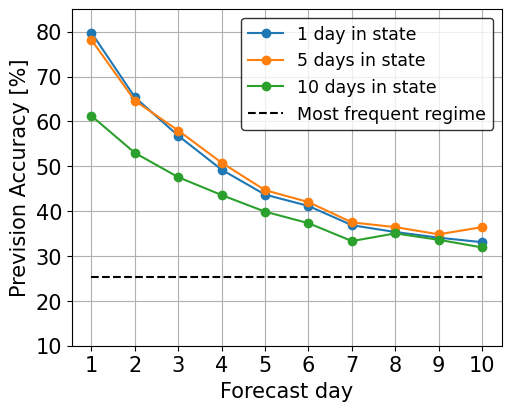

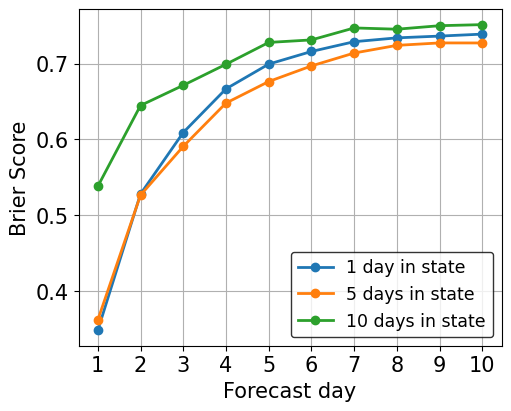

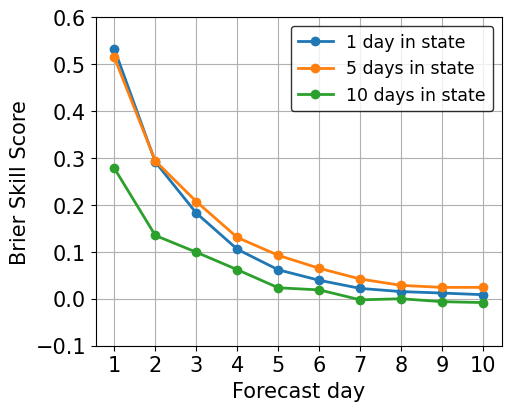

In [61]:
plot_accuracy_score(avg_pred_1_days=avg_pred_4_1_days, avg_pred_5_days=avg_pred_4_5_days, avg_pred_10_days=avg_pred_4_10_days, nb_days_to_forecast=10, validation_predictions=validation_predictions_4, nb_clusters=4)
plot_brier_scores(BS_1_days=BS_4_1_days, BS_5_days=BS_4_5_days, BS_10_days=BS_4_10_days, BS_dummy=mean_dummy_BS_kmeans_4, nb_days_to_forecast=10, nb_clusters=4)
plot_brier_skill_scores(BS_1_days=BS_4_1_days, BS_5_days=BS_4_5_days, BS_10_days=BS_4_10_days, BS_dummy=mean_dummy_BS_kmeans_4, nb_days_to_forecast=10, nb_clusters=4)

In [28]:
avg_pred_8_1_days, BS_8_1_days = compute_forecast_probabilities(nb_days_in_state=1, nb_days_to_forecast=10, year_to_predict=2025, nb_clusters=8, \
                                y_pred_sorted=y_pred_sorted_kmeans_8, transition_probabilities=transition_proba_kmeans_8_1_days)

In [29]:
avg_pred_8_5_days, BS_8_5_days = compute_forecast_probabilities(nb_days_in_state=5, nb_days_to_forecast=10, year_to_predict=2025, nb_clusters=8, \
                                y_pred_sorted=y_pred_sorted_kmeans_8, transition_probabilities=transition_proba_kmeans_8_5_days)

In [30]:
avg_pred_8_10_days, BS_8_10_days = compute_forecast_probabilities(nb_days_in_state=10, nb_days_to_forecast=10, year_to_predict=2025, nb_clusters=8, \
                                y_pred_sorted=y_pred_sorted_kmeans_8, transition_probabilities=transition_proba_kmeans_8_10_days)

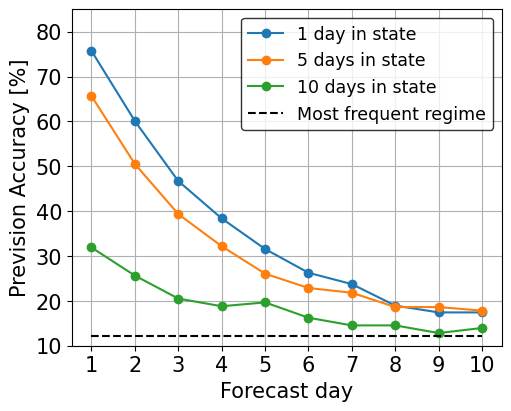

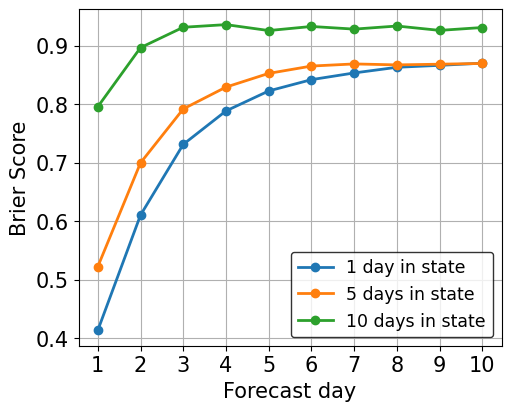

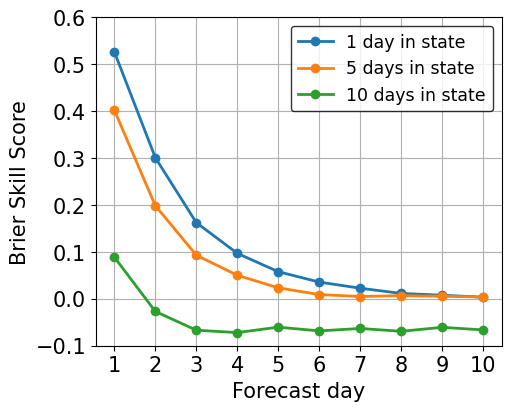

In [62]:
plot_accuracy_score(avg_pred_1_days=avg_pred_8_1_days, avg_pred_5_days=avg_pred_8_5_days, avg_pred_10_days=avg_pred_8_10_days, nb_days_to_forecast=10, validation_predictions=validation_predictions_8, nb_clusters=8)
plot_brier_scores(BS_1_days=BS_8_1_days, BS_5_days=BS_8_5_days, BS_10_days=BS_8_10_days, BS_dummy=mean_dummy_BS_kmeans_8, nb_days_to_forecast=10, nb_clusters=8)
plot_brier_skill_scores(BS_1_days=BS_8_1_days, BS_5_days=BS_8_5_days, BS_10_days=BS_8_10_days, BS_dummy=mean_dummy_BS_kmeans_8, nb_days_to_forecast=10, nb_clusters=8)